Dealing with class imbalance:
- resampling techniques
    - under or over sampling random vs informed
    - SMOTE synthetic minor ...
- kappa statistics/ MCC Metric
- multiclass mcc "comparing two k-category assignments by a k-category correlation coeeficient"


spatial pyramid pooling in deep convolutional networks for visual recognition

In [1]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from pathlib import Path
import keras
import random
from keras.utils import Sequence
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.util import pad
from skimage.util import crop
import numpy as np
import math

Using TensorFlow backend.


In [2]:
class MY_Gen(Sequence):

    def __init__(self, image_filenames, labels, batch_size, shuffle):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.num_labels = len(np.unique(labels))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))
    
    def crop_or_pad(self, image, dim):
        x, y, _ = image.shape
        if y < dim and x < dim:
            image = pad(image, ((math.ceil((dim - image.shape[0])/2),math.floor((dim - image.shape[0])/2)),
                                (math.ceil((dim - image.shape[1])/2),math.floor((dim - image.shape[1])/2)), 
                                (0,0)), 'constant', constant_values = 255)
        elif y > dim and x > dim:
            rand1 = random.randint(1,x-dim)
            rand2 = random.randint(1,y-dim)
            image = crop(image, ((rand1,x-dim-rand1),(rand2,y-dim-rand2),(0,0)))
        elif x > dim:
            rand1 = random.randint(1,x-dim)
            image = pad(image, ((0,0),
                                (math.ceil((dim - y)/2),math.floor((dim - y)/2)), 
                                (0,0)), 'constant', constant_values = 255)
            image = crop(image, ((rand1,x-dim-rand1),
                                (0,0), (0,0)))
        else:
            rand2 = random.randint(1,y-dim)
            image = pad(image, ((math.ceil((dim - x)/2),math.floor((dim - x)/2)),
                                (0,0), 
                                (0,0)), 'constant', constant_values = 255)
            image = crop(image, ((0,0),
                                 (rand2,y-dim-rand2), (0,0)))
        return image
    
    def read_im(self, filename, dim):
        image = imread(filename)
        #image = resize(image, (dim,dim), anti_aliasing = True, mode = "reflect")
        image = skimage.color.gray2rgb(image)
        image = self.crop_or_pad(image, dim)
        return image


    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image = [self.read_im(filename, 299) for filename in batch_x]
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        #batch_y = keras.utils.to_categorical(batch_y, self.num_labels)
        return np.array(image), np.array(batch_y)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            fnames_and_labels = list(zip(self.image_filenames, self.labels))
            random.shuffle(fnames_and_labels)
            self.image_filenames, self.labels = zip(*fnames_and_labels)

In [3]:

path = './data/test/'
def fetch_data_set(path, ftype = 'jpg'):
    p = Path(path)
    files = list(p.glob('**/*.'+ftype))
    classes = str(files).split('/')
    classes = [classes[i] for i in list(range(2,len(classes),3)) ]
    classnames, indices = np.unique(classes, return_inverse=True)
    dict_classes = dict(zip(classnames, list(range(0,len(classes)))))
    return files, classes, dict_classes

#np.array([dict_[i] for i in classes])

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from itertools import chain

def over_under_sample(files, classes, dict_classes, num_to_undersample = 15000, num_to_oversample = 7500):
    files_array = np.array(files).reshape(-1,1)
    dic = {}
    for i in list(classes):
        dic[i] = dic.get(i,0) + 1

    classes_to_oversample = dict((k, v) for k, v in dic.items() if v < num_to_oversample)
    classes_to_undersample = dict((k, v) for k, v in dic.items() if v > num_to_undersample)    
    
    for key, value in classes_to_undersample.items():
        classes_to_undersample[key] = num_to_undersample
    for key, value in classes_to_oversample.items():
        classes_to_oversample[key] = num_to_oversample
    
    ros = RandomOverSampler(sampling_strategy = classes_to_oversample)
    rus = RandomUnderSampler(sampling_strategy = classes_to_undersample)
    x_over, y_over = ros.fit_resample(files_array, classes)
    x_under, y_under = rus.fit_resample(x_over, y_over)
    x_under = list(chain(*x_under.tolist()))
    return x_under, y_under
    
from sklearn.model_selection import train_test_split

def split_data_train_validation_test(data_X, data_Y, test_percent, validation_percent, seed): 
    assert (test_percent < 1) and (0 < validation_percent) and (validation_percent < 1)
    X_tmp, X_val, Y_tmp, Y_val = train_test_split(data_X, data_Y, test_size=validation_percent, shuffle=True, random_state=seed)
    
    if test_percent != 0:
        relative_test_percent = test_percent / (1 - validation_percent)
        X_train, X_test, Y_train, Y_test = train_test_split(X_tmp, Y_tmp, test_size=relative_test_percent, shuffle=True, random_state=seed)
        split_data = [X_train, Y_train, X_val, Y_val, X_test, Y_test]
    else:
        X_train, Y_train = X_tmp, Y_tmp
        split_data = [X_train, Y_train, X_val, Y_val]

    return split_data  

def encode_labels(labels, OneHot=True, encoder = None):
    if OneHot and encoder == None:
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder()
        enc.fit(np.array(labels).reshape(-1, 1))
        OneHot = enc.transform(np.array(labels).reshape(-1, 1)).toarray()
        return OneHot, enc
    else:
        OneHot = encoder.transform(np.array(labels).reshape(-1, 1)).toarray()
        return OneHot
    # mlb 
    #1 convert labels to multilabel using hardcoded dict
    #2 fit mlb
    #3 transform 
    # return labels and encoder
    # repeat for when encoder is present
 


In [4]:
# read dataset
files, classes, dict_classes = fetch_data_set("./data/test/")
# split dataset
split = split_data_train_validation_test(files, classes, 0.05, .25, random.randint(1,10000))
split[0], split[1] = over_under_sample(split[0], split[1], dict_classes, num_to_oversample = 150)
# load label encoder and transform labels
split[1], OH_enc = encode_labels(split[1], OneHot = True)





#from collections import Counter
#print(sorted(Counter(classes).items()))
#print(sorted(Counter(y_re).items()))

/home/florianmuthreich/.local/lib/python3.5/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (150) in class dolio will be larger than the number of samples in the majority class (class #dolio -> 72)
  n_samples_majority))
/home/florianmuthreich/.local/lib/python3.5/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (150) in class onca will be larger than the number of samples in the majority class (class #dolio -> 72)
  n_samples_majority))
/home/florianmuthreich/.local/lib/python3.5/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (150) in class cavo will be larger than the number of samples in the majority class (class #dolio -> 72)
  n_samples_majority))


In [8]:
#c,_= np.unique(split[5], return_inverse=True)
#len(c)
#b = {}
#for i in list(split[5]):
#    b[i] = b.get(i,0) + 1

#counts = dict((k, v) for k, v in b.items() if v > 1)
#counts

#f, c, d = fetch_data_set('./data/imgs')
#d['cavo'] = [0,1,1]
#[d[i] for i in c]
d_ = d
d_['Annelida'] = ['Annelida', 'Metazoa', 'Eukaryota']
d_['Bivalvia__Molusca'] = ['Bivalvia__Molusca', 'Mollusca', 'Metazoa', 'Eukaryota']
d_['Brachyura'] = ['Brachyura', 'Decapoda', 'Malacostraca', 'Arthropoda', 'Metazoa', 'Eukaryota']
d_['Candaciidae'] = ['Candaciidae', 'Calanoida', 'Copepoda', 'Maxillopoda', 'Arthropoda', 'Metazoa', 'Eukaryota']


{'Annelida': 0,
 'Bivalvia__Mollusca': 1,
 'Brachyura': 2,
 'Candaciidae': 3,
 'Cavoliniidae': 4,
 'Centropagidae': 5,
 'Corycaeidae': 6,
 'Coscinodiscus': 7,
 'Decapoda': 8,
 'Doliolida': 9,
 'Eucalanidae': 10,
 'Euchaetidae': 11,
 'Evadne': 12,
 'Foraminifera': 13,
 'Fritillariidae': 14,
 'Haloptilus': 15,
 'Harpacticoida': 16,
 'Limacinidae': 17,
 'Noctiluca': 18,
 'Oikopleuridae': 19,
 'Oncaeidae': 20,
 'Ostracoda': 21,
 'Penilia': 22,
 'Phaeodaria': 23,
 'Salpida': 24,
 'Temoridae': 25,
 'calyptopsis': 26,
 'cyphonaute': 27,
 'egg__Actinopterygii': 28,
 'egg__other': 29,
 'eudoxie__Diphyidae': 30,
 'gonophore__Diphyidae': 31,
 'multiple__Copepoda': 32,
 'multiple__other': 33,
 'nauplii__Cirripedia': 34,
 'nauplii__Crustacea': 35,
 'nectophore__Diphyidae': 36,
 'tail__Appendicularia': 37,
 'tail__Chaetognatha': 38,
 'zoea__Decapoda': 39}

In [225]:
p = Path('./data/test/') 
files = list(p.glob('**/*.jpg'))
classes = str(files).split('/')
classes = [classes[i] for i in list(range(2,len(classes),3)) ]
classnames, indices = np.unique(classes, return_inverse=True)
labels = keras.utils.to_categorical(indices, len(np.unique(indices)))

In [156]:
p = Path('./data/imgs/') 
files = list(p.glob('**/*.jpg'))
classes = str(files).split('/')
classes = [classes[i] for i in list(range(2,len(classes),3)) ]
classnames, indices = np.unique(classes, return_inverse=True)

In [8]:
len(split[1])

22500

In [182]:
np.std(list(counts.values()))
counts
classes_to_oversample = dict((k, v) for k, v in b.items() if v < 7500)
classes_to_undersample = dict((k, v) for k, v in b.items() if v > 15000)
#assign new target values for sampling
for key, value in classes_to_undersample.items():
    classes_to_undersample[key] = 15000
classes_to_undersample.values()

dict_values([15000, 15000, 15000, 15000])

In [185]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [194]:
from sklearn.model_selection import train_test_split

def split_data_train_validation_test(data_X, data_Y, test_percent, validation_percent, seed): 
    assert (test_percent < 1) and (0 < validation_percent) and (validation_percent < 1)
    X_tmp, X_val, Y_tmp, Y_val = train_test_split(data_X, data_Y, test_size=validation_percent, shuffle=True, random_state=seed)
    
    if test_percent != 0:
        relative_test_percent = test_percent / (1 - validation_percent)
        X_train, X_test, Y_train, Y_test = train_test_split(X_tmp, Y_tmp, test_size=relative_test_percent, shuffle=True, random_state=seed)
        split_data = [X_train, Y_train, X_val, Y_val, X_test, Y_test]
    else:
        X_train, Y_train = X_tmp, Y_tmp
        split_data = [X_train, Y_train, X_val, Y_val]

    return split_data

split = split_data_train_validation_test(files, classes, 0, .25, 1190)

In [147]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
d = {0: 150, 1: 300}
ros = RandomOverSampler(random_state = 0, sampling_strategy = d)
x_re, y_re = ros.fit_resample(np.array(split[0]).reshape(-1,1), split[1])
from collections import Counter
print(sorted(Counter(split[1]).items()))
print(sorted(Counter(y_re).items()))

[(0, 75), (1, 78), (2, 72)]
[(0, 150), (1, 300), (2, 72)]


/home/florianmuthreich/.local/lib/python3.5/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (150) in class 0 will be larger than the number of samples in the majority class (class #1 -> 78)
  n_samples_majority))
/home/florianmuthreich/.local/lib/python3.5/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (300) in class 1 will be larger than the number of samples in the majority class (class #1 -> 78)
  n_samples_majority))


In [153]:
from itertools import chain

x_re = list(chain(*x_re.tolist()))
y_re


array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0,
       1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1,
       2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 0,
       0, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1,
       0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1,
       1, 2, 2, 0, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0,
       2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1,
       1, 2, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2,
       2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [16]:
#import keras_metrics
#metrics=[keras_metrics.precision(), keras_metrics.recall()
b = {}
for i in list(np.array(x_re)):
    b[i] = b.get(i,0) + 1

dict((k, v) for k, v in b.items() if v > 1)

#x_re

TypeError: unhashable type: 'numpy.ndarray'

In [5]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import keras_metrics
from keras import backend as K

base_model = InceptionV3(weights='imagenet', include_top=False)


x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [5]:
batch_size=30
#num_training_samples=len(files)

files, classes, dict_classes =  fetch_data_set('./data/test')
split = split_data_train_validation_test(files, classes, .1, .25, 666)

In [71]:
pd.crosstab(np.array([dict_classes[i] for i in split[5]]), (test_pred), rownames=['Actual'], colnames=['Predicted'], margins=True)
#len(split[5]), len(test_pred)
#len(np.argmax(model_pred, axis = 1, out = None)), len(test_pred), len(split[5])
#[dict_classes[i] for i in split[5]], list(test_pred)

AttributeError: 'dict' object has no attribute 'get_key'

In [58]:
#[dict_classes[i] for i in split[1]]
import pandas as pd
model_pred = model.predict_generator(generator = test_batch, steps = (len(split[4]) // batch_size))
#test_actu = np.argmax([dict_classes[i] for i in split[5]], axis = 1, out = None)
test_pred = np.argmax(model_pred, axis = 1, out = None)
pd.crosstab(split[5], test_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


AssertionError: arrays and names must have the same length

In [6]:
batch_size = 30
training_batch = MY_Gen(split[0], split[1], batch_size, shuffle = True)
#validation_batch = MY_Gen(split[2], [dict_classes[i] for i in split[3]], batch_size, shuffle = True)#files, indices
#test_batch = MY_Gen(split[4], [dict_classes[i] for i in split[5]], batch_size, shuffle = False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras_metrics.precision(), keras_metrics.recall(),'accuracy'])

history = model.fit_generator(generator=training_batch,
                    #validation_data = validation_batch,
                    #validation_steps = (len(split[2]) // batch_size),
                    steps_per_epoch=(len(split[0]) // batch_size),
                    epochs=5,
                    verbose=1,
                    use_multiprocessing=False,
                    workers=16,
                    max_queue_size=32)

Epoch 1/5
15/15 [==============================] - 4s 247ms/step - loss: 1.0279 - precision: 0.6165 - recall: 0.5467 - acc: 0.6689
Epoch 2/5
15/15 [==============================] - 3s 183ms/step - loss: 0.2488 - precision: 0.8718 - recall: 0.9067 - acc: 0.9111
Epoch 3/5
15/15 [==============================] - 3s 180ms/step - loss: 0.1092 - precision: 0.9662 - recall: 0.9533 - acc: 0.9667
Epoch 4/5
15/15 [==============================] - 3s 177ms/step - loss: 0.0596 - precision: 0.9671 - recall: 0.9800 - acc: 0.9822
Epoch 5/5
15/15 [==============================] - 3s 177ms/step - loss: 0.0876 - precision: 0.9533 - recall: 0.9533 - acc: 0.9689


In [74]:
import pandas as pd
#split[5] = encode_labels(split[5], OneHot=True, encoder = OH_enc)
test_batch = MY_Gen(split[4], split[5], 15, shuffle = False)
model_pred = model.predict_generator(generator = test_batch, steps = (len(split[4]) // 15))
t = {v: k for k, v in dict_classes.items()}
test_actu = OH_enc.inverse_transform(split[5]).flatten()
test_pred = t[i] for i in np.argmax(model_pred, axis = 1, out = None)
pd.crosstab(test_actu, test_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,All
Actual,,,,
cavo,4,1,0,5
dolio,0,6,0,6
onca,0,3,1,4
All,4,10,1,15


Your classifier probably misclassifies some images. Investigate how well the accuracy of the
classifications match the softmax output values, for instance as a histogram with softmax
intervals (buckets) on the x-axis (e.g. 0.70-0.75), and the percentage correct classifications for
each bucket (e.g. 68%) on the y-axis. Is your classifier overconfident or underconfident, or
neutral?

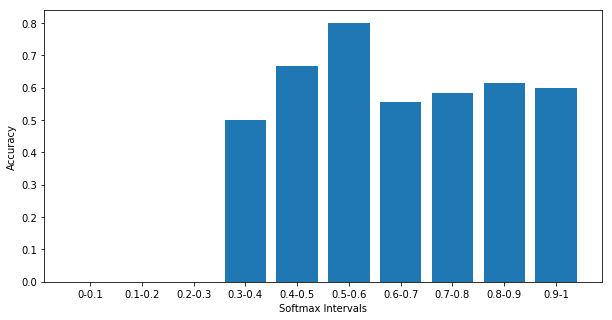

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [34]:
#plt.hist(acc)
#plt.show()
plt.figure(figsize=(10,5))
plt.bar(np.arange(0,10,1), height = acc.flatten())
plt.xticks(np.arange(0,10,1), ['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1'])
plt.xlabel("Softmax Intervals")
plt.ylabel("Accuracy")
plt.title("Sofmax calibration")
plt.show()
plt.hist()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
bins = np.arange(0,1.1,0.1)
rng = np.random.RandomState(10)
acc = np.zeros([10,1])
pred = np.array(rng.normal(.5,.25,size=15)).reshape(5,3)
actu = np.repeat(np.array([False,True,False,True,True]), 3)
for i in range(len(bins)-1):
    tmp = ((pred < bins[i]).flatten() & (pred < bins[i+1]).flatten())
    if sum(tmp) == 0:
        acc[i] = 0
    else:
        acc[i] = sum(tmp * actu)/sum(tmp)

acc

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.5       ],
       [0.66666667],
       [0.8       ],
       [0.55555556],
       [0.58333333],
       [0.61538462],
       [0.6       ]])

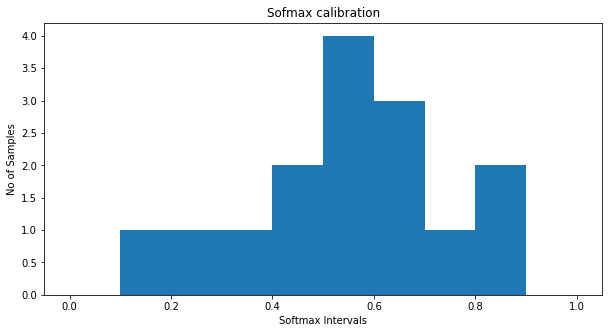

In [79]:
plt.figure(figsize=(10,5))
plt.hist(pred.flatten(), range = (0,1))
plt.xlabel("Softmax Intervals")
plt.ylabel("No of Samples")
plt.title("Sofmax calibration")
plt.show()


In [144]:
json_string = model.to_json()
with open("data/output/models/pretra_INC.json", "w") as json_file:
    json_file.write(json_string)

model.save_weights("data/output/models/pretra_INC_weights.hdf5")

In [ ]:
#im=np.asarray(Image.open(files[1]).resize([299,299]))
#im = im/np.amax(im)
#import matplotlib.pyplot as plt
#plt.imshow(image[7])
#plt.show()
#ind = np.arange(105)
#isinstance(classes, list)
#len(classes)
import random
c=list(zip(files,classes))
random.shuffle(c)
files,classes = zip (*c)

In [ ]:
import skimage
im = resize(imread(files[1]), (100, 100))
im = skimage.color.gray2rgb(im)
im.shape

In [ ]:
#im = np.array([(Image.open(file_name).resize([299,299])) for file_name in files])
#im2 = np.array([
           # resize(imread(file_name), (299, 299))
            #   for file_name in files])
#len(im2)
#im2.shape
#im.shape
def norm_im(filename, dim):
    image = imread(filename)
    image = resize(image, (dim,dim), mode = "edge")
    image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
    return image
image = np.array([norm_im(filename, 100) for filename in files])


image.shape

In [33]:
#files[range(1,10)]
list(indices)
keras.utils.to_categorical(indices, 5)
len(np.unique(indices))

3

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')




In [ ]:
batch_size=100
num_training_samples=len(files)
# compile the model (should be done *after* setting layers to non-trainable)
my_training_batch_generator = MY_Gen(files, labels, batch_size)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])
# train the model on the new data for a few epochs
model.fit_generator(generator=my_training_batch_generator,
                                          steps_per_epoch=(num_training_samples // batch_size),
                                          epochs=10,
                                          verbose=1,
                                          use_multiprocessing=False,
                                          workers=16,
                                          max_queue_size=32,
                             shuffle = True)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.



In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

In [ ]:
from pathlib import Path
p = Path('./data/imgs/') 
classes = [x for x in p.iterdir() if x.is_dir()]
files = list(p.glob('**/*.jpg'))

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
labels = [
    ("legs","blue", "jeans"),
    ("no_legs","blue", "dress"),
    ("no_legs","red", "dress"),
    ("no_legs","red", "shirt"),
    ("no_legs","blue", "shirt"),
    ("no_legs","black", "jeans")]
mlb = MultiLabelBinarizer()
mlb.fit(labels)

mlb.classes_

mlb.transform([("blue", "dress", "no_legs")]), mlb.inverse_transform(np.array([[0, 1, 1, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 1, 0, 0]]))
#np.array()

(array([[0, 1, 1, 0, 0, 1, 0, 0]]),
 [('blue', 'dress', 'no_legs'), ('black', 'blue', 'dress', 'no_legs')])

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.array(split[5]).reshape(-1, 1))
OneHot=enc.transform(np.array(split[5]).reshape(-1, 1)).toarray()
#enc.inverse_transform(OneHot)
OneHot[1:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [17]:
p = Path('./data/test')
end = '.jpg'
list(p.glob('**/*'+end))


[PosixPath('data/test/cavo/992612.jpg'),
 PosixPath('data/test/cavo/1158831.jpg'),
 PosixPath('data/test/cavo/993180.jpg'),
 PosixPath('data/test/cavo/996279.jpg'),
 PosixPath('data/test/cavo/12747088.jpg'),
 PosixPath('data/test/cavo/1158620.jpg'),
 PosixPath('data/test/cavo/992773.jpg'),
 PosixPath('data/test/cavo/994128.jpg'),
 PosixPath('data/test/cavo/1158767.jpg'),
 PosixPath('data/test/cavo/996858.jpg'),
 PosixPath('data/test/cavo/993866.jpg'),
 PosixPath('data/test/cavo/993300.jpg'),
 PosixPath('data/test/cavo/12746529.jpg'),
 PosixPath('data/test/cavo/12746695.jpg'),
 PosixPath('data/test/cavo/12746864.jpg'),
 PosixPath('data/test/cavo/1158573.jpg'),
 PosixPath('data/test/cavo/12747169.jpg'),
 PosixPath('data/test/cavo/994685.jpg'),
 PosixPath('data/test/cavo/993520.jpg'),
 PosixPath('data/test/cavo/995387.jpg'),
 PosixPath('data/test/cavo/993928.jpg'),
 PosixPath('data/test/cavo/1158518.jpg'),
 PosixPath('data/test/cavo/12747201.jpg'),
 PosixPath('data/test/cavo/993824.jpg'),